
Training fold 1...
Validation Accuracy for fold 1: 0.9918

Training fold 2...
Validation Accuracy for fold 2: 0.9939

Training fold 3...
Validation Accuracy for fold 3: 0.9939

Training fold 4...
Validation Accuracy for fold 4: 0.9918

Training fold 5...
Validation Accuracy for fold 5: 0.9939

Average Accuracy across all folds: 0.9931
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Confusion Matrix:
 [[225   1   0   0   0]
 [  0  65   0   0   0]
 [  0   0  57   0   0]
 [  1   0   0  55   0]
 [  1   0   0   0  85]]


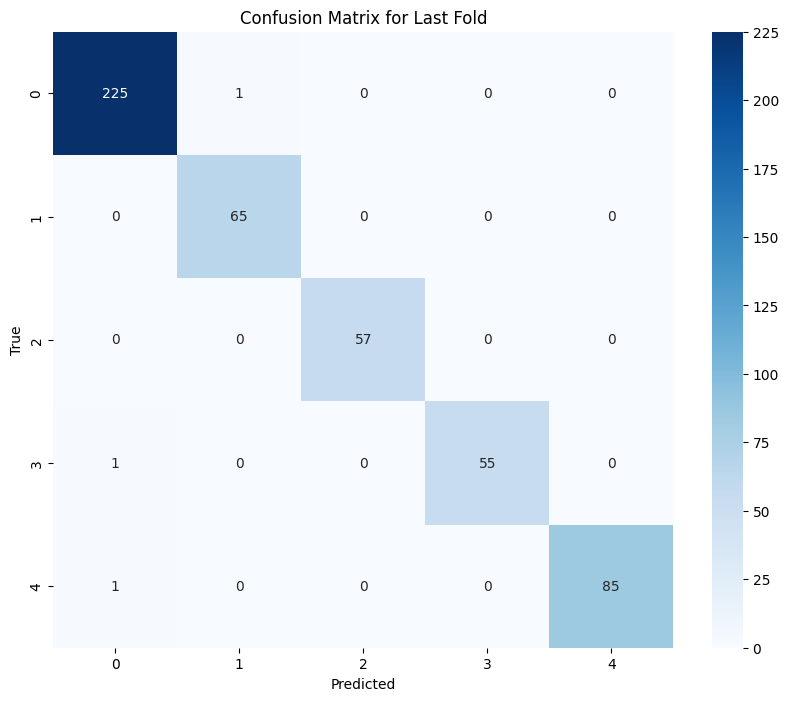

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Extract features and labels
features = data[['I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat', 'Lng', 'Alt',
                 'Spd', 'GCrs', 'VZ', 'Yaw', 'U']].values  # Update to match the correct feature columns
labels = data['labels'].values  # Replace with the correct column for labels

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# One-hot encode the labels for multiclass classification
num_classes = len(np.unique(labels))  # Number of classes
labels = to_categorical(labels, num_classes=num_classes)

# Reshape for TCN (input needs to be 3D: [samples, time_steps, features])
features = features.reshape((features.shape[0], 1, features.shape[1]))

# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism after the TCN layers
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# Input shape (1 time step, number of features)
input_shape = (1, features.shape[2])  # Adjust to match the number of features

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

for train_index, val_index in kf.split(features):
    print(f"\nTraining fold {fold_no}...")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = features[train_index], features[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on the validation set
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)
    fold_no += 1

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")

# Visualize the Confusion Matrix for the last fold
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_fold, axis=1)

conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix.numpy())

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Last Fold')
plt.show()


In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize features (if not already done earlier in k-fold validation)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0281
Test Loss: 0.017578693106770515
Test Accuracy: 0.9979591965675354
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Confusion Matrix:
 [[252   0   0   0   0]
 [  0  70   0   0   0]
 [  0   0  57   0   0]
 [  1   0   0  45   0]
 [  0   0   0   0  65]]


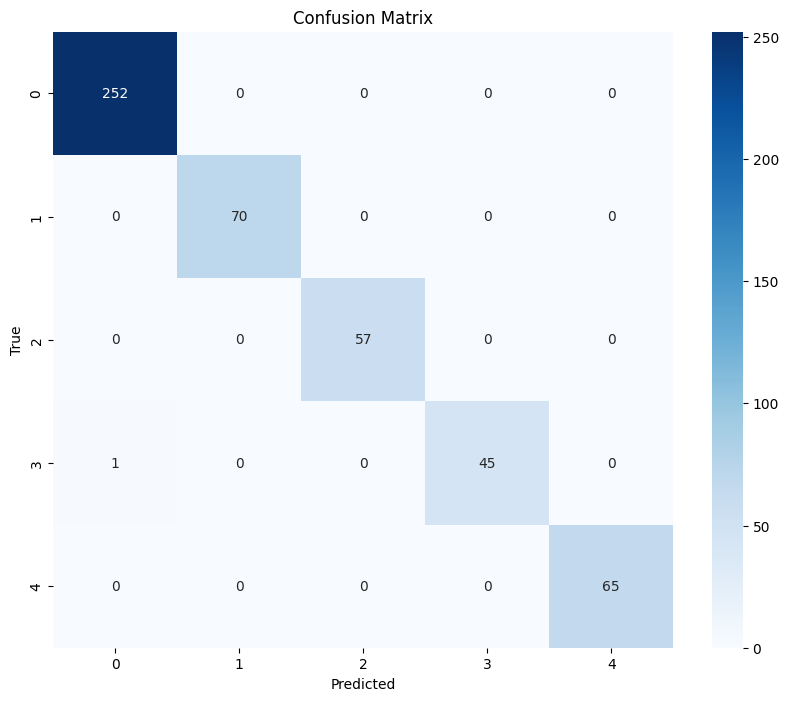

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       252
     Class 1       1.00      1.00      1.00        70
     Class 2       1.00      1.00      1.00        57
     Class 3       1.00      0.98      0.99        46
     Class 4       1.00      1.00      1.00        65

    accuracy                           1.00       490
   macro avg       1.00      1.00      1.00       490
weighted avg       1.00      1.00      1.00       490

Precision: 0.9979672501411633
Recall: 0.9979591836734694
F1 Score: 0.9979499910071743
Accuracy: 0.9979591836734694


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Metrics
report = classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(num_classes)])
print("Classification Report:\n", report)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


In [ ]:
# Accuracy per class
class_accuracies = {}
for i in range(num_classes):
    class_correct = conf_matrix[i, i]
    class_total = conf_matrix[i, :].sum()
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    class_accuracies[f'Class {i}'] = class_accuracy

print("\nAccuracy per Class:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.4f}")



Accuracy per Class:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 0.9783
Class 4: 1.0000


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('/content/jamming-merged-gps-only.csv')
print(data.head())

   timestamp      q[0]      q[1]      q[2]      q[3]  delta_q_reset[0]  \
0  332828103 -0.278094 -0.004139 -0.002317  0.960542          0.999999   
1  333003247 -0.278094 -0.004139 -0.002317  0.960542          0.999999   
2  333008246 -0.278094 -0.004139 -0.002317  0.960542          0.999999   
3  333013247 -0.278096 -0.004139 -0.002316  0.960542          0.999999   
4  333022041 -0.278098 -0.004136 -0.002315  0.960541          0.999999   

   delta_q_reset[1]  delta_q_reset[2]  delta_q_reset[3]  quat_reset_counter  \
0      5.520000e-10     -4.980000e-10          0.001079                   3   
1      5.520000e-10     -4.980000e-10          0.001079                   3   
2      5.520000e-10     -4.980000e-10          0.001079                   3   
3      5.520000e-10     -4.980000e-10          0.001079                   3   
4      5.520000e-10     -4.980000e-10          0.001079                   3   

   ...  v_z_valid  xy_reset_counter  z_reset_counter  vxy_reset_counter  \
0  ..

In [ ]:
# Extract intelligent features and labels
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values
labels = data['label'].values  # Assuming 'label' is the name of the target column


In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [ ]:
# One-hot encode the labels for multiclass classification
# num_classes = len(np.unique(labels))  # Number of classes
# labels = to_categorical(labels, num_classes=num_classes)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the string labels to numeric
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)  # Converts 'benign' -> 0, 'malicious' -> 1

# One-hot encode the numeric labels
num_classes = len(np.unique(numeric_labels))  # Number of classes (2: benign and malicious)
labels = to_categorical(numeric_labels, num_classes=num_classes)

# Verify the mapping
print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")


Label mapping:
0: benign
1: malicious


In [ ]:
features = features.reshape((features.shape[0], 1, features.shape[1]))

In [ ]:
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [ ]:

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output


In [ ]:
def build_tcn_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism after the TCN layers
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [ ]:
# Input shape (1 time step, number of features)
input_shape = (1, features.shape[2])  # Adjust to match the number of features

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

for train_index, val_index in kf.split(features):
    print(f"\nTraining fold {fold_no}...")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = features[train_index], features[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on the validation set
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)
    fold_no += 1


Training fold 1...
Validation Accuracy for fold 1: 1.0000

Training fold 2...
Validation Accuracy for fold 2: 0.9992

Training fold 3...
Validation Accuracy for fold 3: 1.0000

Training fold 4...
Validation Accuracy for fold 4: 1.0000

Training fold 5...
Validation Accuracy for fold 5: 1.0000


In [ ]:
# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.9998


In [ ]:
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_fold, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [ ]:

conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix.numpy())

Confusion Matrix:
 [[981   0]
 [  0 308]]


In [ ]:
# Average accuracy per label
label_accuraciesVIBE = np.mean(label_accuraciesVIBE, axis=0)
for idx, acc in enumerate(label_accuraciesVIBE):
    print(f"Label {idx} Accuracy: {acc:.4f}")

NameError: name 'label_accuraciesVIBE' is not defined

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Extract intelligent features and labels
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values

labels = data['label'].values  # Assuming 'label' is the name of the target column

# Encode the string labels to numeric
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)  # Converts 'benign' -> 0, 'malicious' -> 1

# One-hot encode the numeric labels
num_classes = len(np.unique(numeric_labels))  # Number of classes (2: benign and malicious)
labels = to_categorical(numeric_labels, num_classes=num_classes)

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Reshape for TCN (input needs to be 3D: [samples, time_steps, features])
features = features.reshape((features.shape[0], 1, features.shape[1]))

# Define the TCN Block with Dropout for regularization
def TCN_Block(filters, kernel_size, dilation_rate, dropout_rate=0.2):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate)
    ])

# Define Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism after the TCN layers
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# Input shape (1 time step, 25 features for the GPS data)
input_shape = (1, 25)  # Update the input shape to match the number of features

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
classification_reports = []

for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Build the model
    model = build_tcn_attention_model(input_shape)

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    accuracies.append(accuracy)

    # Generate classification report
    report = classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
    classification_reports.append(report)

# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")

# Calculate average metrics per class
average_metrics = {label: {metric: np.mean([report[label][metric] for report in classification_reports if label in report])
                           for metric in classification_reports[0][list(classification_reports[0].keys())[0]].keys()}
                   for label in classification_reports[0].keys() if isinstance(classification_reports[0][label], dict)}

# Print the average classification report
print("\nClassification Report:")
print(f"{'Class':<10} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
for label, metrics in average_metrics.items():
    print(f"{label:<10} {metrics['precision']:<10.2f} {metrics['recall']:<10.2f} {metrics['f1-score']:<10.2f} {metrics['support']:<10.0f}")

# Calculate overall metrics
overall_metrics = classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_)

print("\nOverall Classification Report:")
print(overall_metrics)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Average Accuracy: 1.0

Classification Report:
Class      precision  recall     f1-score   support   
benign     1.00       1.00       1.00       997       
malicious  1.00       1.00       1.00       292       
macro avg  1.00       1.00       1.00       1289      
weighted avg 1.00       1.00       1.00       1289      

Overall Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00       981
   malicious       1.00      1.00      1.00       308

    accuracy                           1.00      1289
   macro avg       1.00      1.00      1.00      1289
weighted avg       1.00      1.00      1.00      1289



In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Attention, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Example dataset (Replace with your actual dataset)
# X (features) should be a numpy array of shape (num_samples, num_features)
# y (labels) should be a numpy array of shape (num_samples, )
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values

labels = data['label'].values  # Assuming 'label' is the name of the target column



# Preprocess the labels: one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)  # Convert to one-hot encoding

# Reshape the input data to match the model's expected input shape
# For example, if you're working with time series data, you might reshape like this:
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])  # (samples, time steps, features)

# Define the input shape and number of classes
input_shape = (1, 25)  # Modify this based on your dataset (1 time step and 25 features)
num_classes = 2  # Number of classes (binary classification in this case)

# Function to build the TCN + Attention model
def TCN_Block(filters, kernel_size, dilation_rate):
    return layers.Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')

def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = Attention()([x, x])

    # Flatten the output to make it compatible with Dense layer
    attention_output = Flatten()(attention_output)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1

# Print results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Label-wise Accuracies: {label_accuracies}")

# Optionally, summarize the model's architecture after training all folds
model.summary()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Accuracy for fold 1: 0.4700
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training fold 2...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Accuracy for fold 2: 0.4650
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training fold 3...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Accuracy for fold 3: 0.5350
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training fold 4...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Accuracy for fold 4: 0.5550
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training fold 5...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Validation Accuracy for fold 5: 0.4800
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Cross-validation Results:
Mean Accuracy: 0.5010
Label-wise Accuracies: [[0.5104166666666666, 0.4326923076923077], [0.4948453608247423, 0.4368932038834951], [0.5483870967741935, 0.5233644859813084], [0.5714285714285714, 0.5340909090909091], [0.48484848484848486, 0.4752475247524752]]


Model: "functional_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_230           │ (None, 1, 25)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_206 (Conv1D)       │ (None, 1, 64)          │          4,864 │ input_layer_230[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_207 (Conv1D)       │ (None, 1, 64)          │         12,352 │ conv1d_206[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_208 (Conv1D)       │ (None, 1, 64)          │         12,352 │ conv1d_207[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_16 (Attention)  │ (None, 1, 64)          │              0 │ conv1d_208[0][0],      │
│                           │                        │                │ conv1d_208[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_22 (Flatten)      │ (None, 64)             │              0 │ attention_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 2)              │            130 │ flatten_22[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 89,096 (348.04 KB)

 Trainable params: 29,698 (116.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,398 (232.03 KB)

Label Distribution:
label
benign       4985
malicious    1460
Name: count, dtype: int64

Summary Statistics:
             lat_x        lon_x        alt_x  alt_ellipsoid_x         lat_y  \
count  6445.000000  6445.000000  6445.000000      6445.000000  6.445000e+03   
mean     36.204813   138.252924    44.400868        86.167133  3.620481e+08   
std       0.000011     0.000013     0.321248         0.784532  1.142135e+02   
min      36.204796   138.252895    43.499966        85.096880  3.620479e+08   
25%      36.204806   138.252918    44.241749        85.536100  3.620481e+08   
50%      36.204812   138.252921    44.435590        85.980341  3.620481e+08   
75%      36.204813   138.252924    44.582573        86.521100  3.620481e+08   
max      36.204854   138.252973    45.196880        88.414220  3.620485e+08   

              lon_y         alt_y  alt_ellipsoid_y      vel_m_s    vel_n_m_s  \
count  6.445000e+03   6445.000000      6445.000000  6445.000000  6445.000000   
mean   1.382529e+09

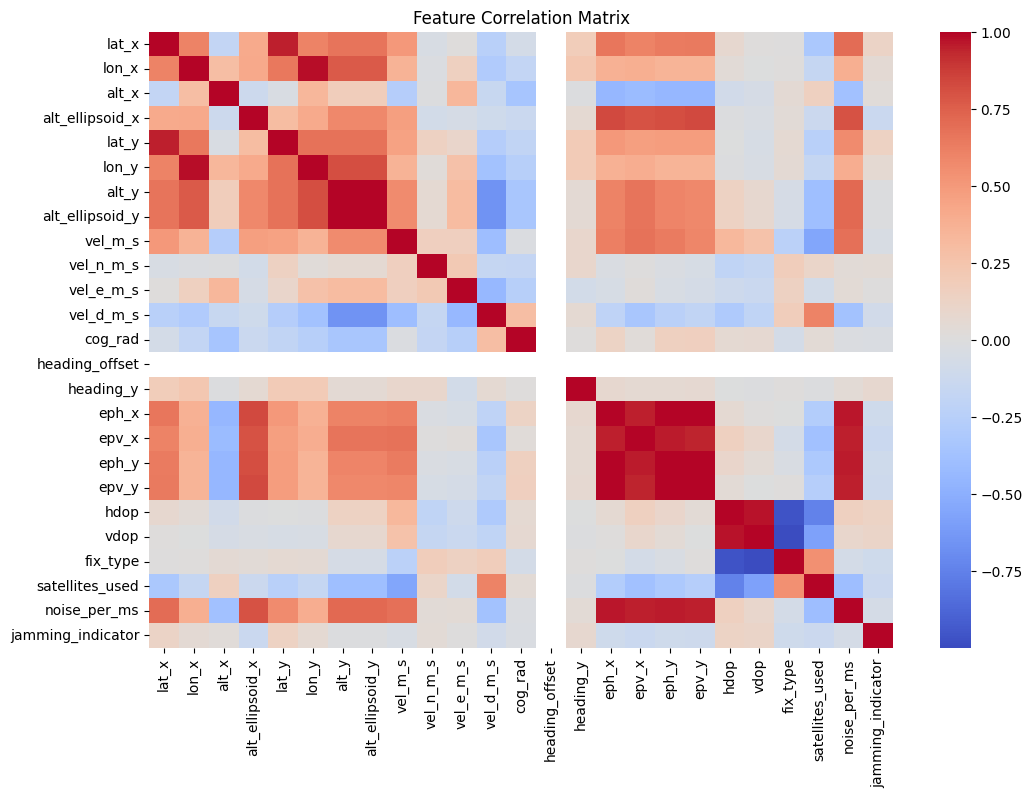

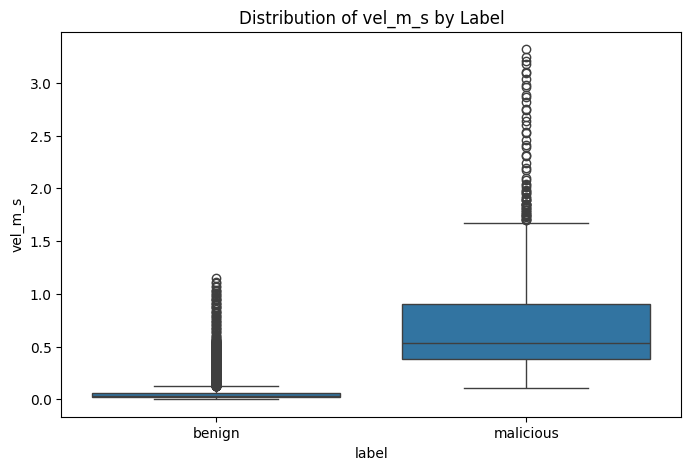

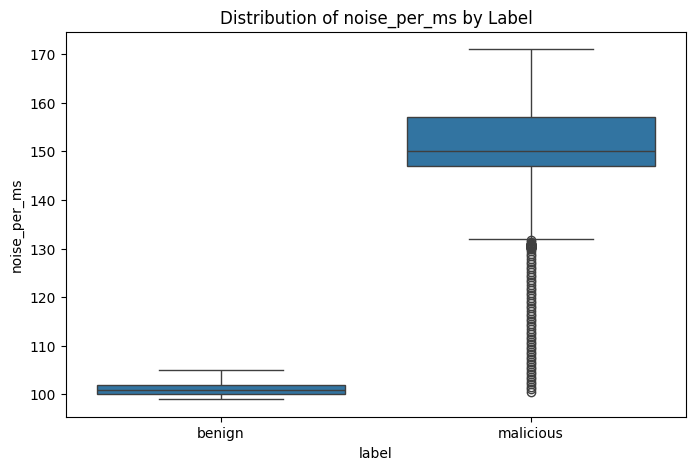

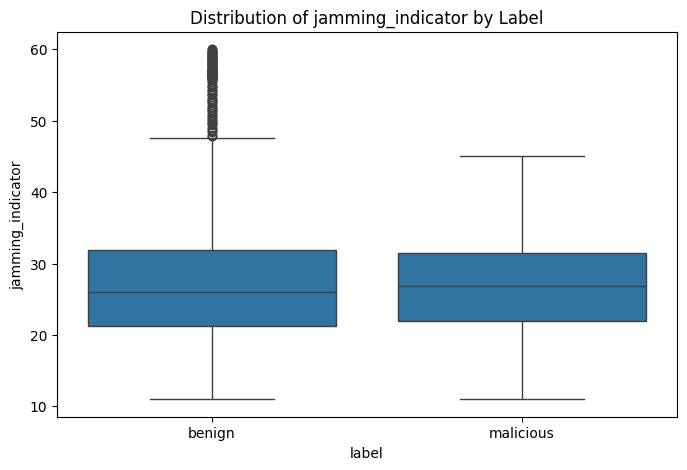

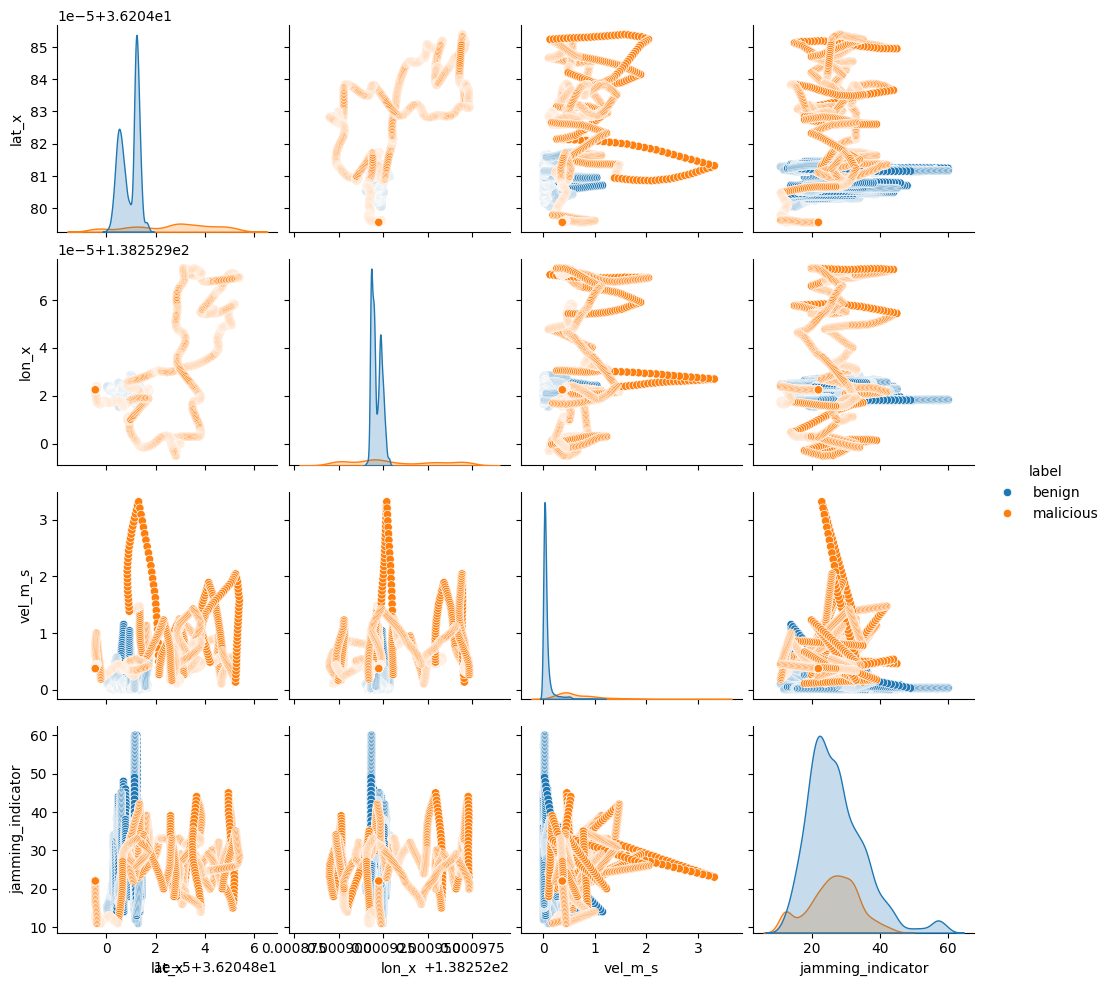

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Extract features and labels
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']]
labels = data['label']

# 1. Label distribution
print("Label Distribution:")
print(labels.value_counts())

# 2. Summary statistics for features
print("\nSummary Statistics:")
print(features.describe())

# 3. Correlation matrix
correlation_matrix = features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# 4. Visualize feature distributions per label
for feature in ['vel_m_s', 'noise_per_ms', 'jamming_indicator']:  # Select a few key features
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=labels, y=features[feature])
    plt.title(f"Distribution of {feature} by Label")
    plt.show()

# 5. Pairplot for some features
sns.pairplot(data, vars=['lat_x', 'lon_x', 'vel_m_s', 'jamming_indicator'], hue='label')
plt.show()


In [ ]:
# Check the distribution of labels in the dataset
label_counts = data['label'].value_counts()

# Print the count for each label
print("Number of entries for each label:")
print(label_counts)

# If you specifically want counts for 'benign' and 'malicious'
benign_count = label_counts.get('benign', 0)  # Default to 0 if 'benign' is not in the labels
malicious_count = label_counts.get('malicious', 0)  # Default to 0 if 'malicious' is not in the labels

print(f"\nNumber of 'benign' entries: {benign_count}")
print(f"Number of 'malicious' entries: {malicious_count}")


Number of entries for each label:
label
benign       4985
malicious    1460
Name: count, dtype: int64

Number of 'benign' entries: 4985
Number of 'malicious' entries: 1460


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Example data preprocessing
# X and y should be your features and labels
data = pd.read_csv('/content/spoofing-merged-gps-only.csv')
# Replace these with your actual data
# Example of feature data X (25 features for example)
X = np.random.rand(1000, 25)  # Placeholder, replace with your actual data

# Example of labels y (binary classification for example, 2 classes)
y = np.random.randint(2, size=(1000, 1))  # Placeholder, replace with your actual labels

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_encoded = to_categorical(y, num_classes=2)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for TCN input (adding 1D time dimension)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Define the input shape and number of classes
input_shape = (1, 25)  # Modify based on your actual data dimensions
num_classes = 2  # Modify based on your number of classes

# Define TCN block (you can modify filters and kernel_size as needed)
def TCN_Block(filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')

# Build model with TCN and attention
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Add TCN layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Add dropout to reduce overfitting
    x = Dropout(0.3)(x)

    # Add attention mechanism
    attention_output = Attention()([x, x])

    # Flatten the attention output
    attention_output = Flatten()(attention_output)

    # Final dense layer for classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

# Define callbacks: Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# K-fold cross-validation loop
for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split the data for current fold
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping, lr_scheduler])

    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    fold_no += 1

# Print final cross-validation results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")



Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Validation Accuracy for fold 1: 0.5000

Training fold 2...
Validation Accuracy for fold 2: 0.5200

Training fold 3...

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Validation Accuracy for fold 3: 0.5100

Training fold 4...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Validation Accuracy for fold 4: 0.6050

Training fold 5...

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Validation Accuracy for fold 5: 0.5550

Cross-validation Results:
Mean Accuracy: 0.5380


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Attention, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the dataset (replcsvace 'your_dataset.csv' with the path to your actual dataset file)
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Example dataset (Replace with your actual dataset)
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values

labels = data['label'].values  # Assuming 'label' is the name of the target column

# Preprocess the labels: one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_encoded = to_categorical(y_encoded)  # Convert to one-hot encoding

# Reshape the input data to match the model's expected input shape
X_reshaped = features.reshape(features.shape[0], 1, features.shape[1])  # (samples, time steps, features)

# Define the input shape and number of classes
input_shape = (1, 25)  # Modify this based on your dataset (1 time step and 25 features)
num_classes = 2  # Number of classes (binary classification in this case)

# Function to build the TCN + Attention model
def TCN_Block(filters, kernel_size, dilation_rate):
    return layers.Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')

def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = Attention()([x, x])

    # Flatten the output to make it compatible with Dense layer
    attention_output = Flatten()(attention_output)

    # Classification
    classification = Dense(1, activation='sigmoid')(attention_output)  # Use sigmoid for binary classification

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    # Print classification report
    print(f"\nClassification Report for fold {fold_no}:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    fold_no += 1

# Print results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Label-wise Accuracies: {label_accuracies}")

# Optionally, summarize the model's architecture after training all folds
model.summary()



Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Attention, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Example dataset (Replace with your actual dataset)
# X (features) should be a numpy array of shape (num_samples, num_features)
# y (labels) should be a numpy array of shape (num_samples, )
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values

labels = data['label'].values  # Assuming 'label' is the name of the target column

# Preprocess the labels: one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_encoded = to_categorical(y_encoded)  # Convert to one-hot encoding

# Reshape the input data to match the model's expected input shape
X_reshaped = features.reshape(features.shape[0], 1, features.shape[1])  # (samples, time steps, features)

# Define the input shape and number of classes
input_shape = (1, 25)  # Modify this based on your dataset (1 time step and 25 features)
num_classes = 2  # Number of classes (binary classification in this case)

# Function to build the TCN + Attention model
def TCN_Block(filters, kernel_size, dilation_rate):
    return layers.Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='relu')

def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = Attention()([x, x])

    # Flatten the output to make it compatible with Dense layer
    attention_output = Flatten()(attention_output)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.002),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1

# Print results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Label-wise Accuracies: {label_accuracies}")

# Optionally, summarize the model's architecture after training all folds
model.summary()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load and preprocess the dataset
data = pd.read_csv('/content/spoofing-merged-gps-only.csv')

# Extract features and labels
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values

labels = data['label'].values

# Encode the string labels to numeric
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# One-hot encode the numeric labels
num_classes = len(np.unique(numeric_labels))
labels = to_categorical(numeric_labels, num_classes=num_classes)

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Reshape for TCN (input needs to be 3D: [samples, time_steps, features])
features = features.reshape((features.shape[0], 1, features.shape[1]))

# Define the TCN Block with Dropout for regularization
def TCN_Block(filters, kernel_size, dilation_rate, dropout_rate=0.3, weight_decay=1e-4):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate,
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(dropout_rate)
    ])

# Define the TCN Model
def build_tcn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = TCN_Block(filters=32, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=32, kernel_size=3, dilation_rate=8)(x)

    # Classification
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Add L2 regularization to dense layers
    x = Dropout(0.5)(x)  # Increase dropout in fully connected layer
    classification = Dense(num_classes, activation='softmax', name='classification')(x)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=numeric_labels)

# Class weights to address imbalance
class_weights = {i: len(numeric_labels) / (num_classes * np.bincount(numeric_labels)[i]) for i in range(num_classes)}

# Build the model
input_shape = (1, 25)  # Match the number of features
model = build_tcn_model(input_shape, num_classes)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32,
                    class_weight=class_weights, callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy and Classification Report
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"\nROC-AUC Score: {roc_auc:.4f}")


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5818 - loss: 0.5598 - val_accuracy: 1.0000 - val_loss: 0.3170 - learning_rate: 0.0010
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.1609 - val_accuracy: 1.0000 - val_loss: 0.0886 - learning_rate: 0.0010
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.1027 - val_accuracy: 1.0000 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0722 - val_accuracy: 1.0000 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0765 - val_accuracy: 1.0000 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.0607 - val_accuracy: 1.0000 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0259 - val_accuracy

LSTM ATTENTION

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('/content/spoofing-merged-gps-only.csv')

# Extract features and labels
features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y',
                 'alt_y', 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s',
                 'vel_d_m_s', 'cog_rad', 'heading_offset', 'heading_y', 'eph_x',
                 'epv_x', 'eph_y', 'epv_y', 'hdop', 'vdop', 'fix_type',
                 'satellites_used', 'noise_per_ms', 'jamming_indicator']].values
labels = data['label'].values  # Binary labels

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Ensure labels are binary (if not already 0 and 1)
labels = np.array(labels)

# Define Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define LSTM with Attention Model
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # Attention mechanism
    attention_output = AttentionLayer()(lstm_out)

    # Classification
    classification = Dense(1, activation='sigmoid', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Input shape (1 time step, 24 features for the GPS spoofing dataset)
input_shape = (1, 24)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, val_index in kf.split(features):
    X_train, X_val = features[train_index], features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Reshape for LSTM (input needs to be 3D: [samples, time_steps, features])
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build and train the model
    model = build_lstm_attention_model(input_shape)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=False)

    # Evaluate the model
    _, val_acc = model.evaluate(X_val, y_val)
    accuracies.append(val_acc)

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

# Plot the accuracies for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title('K-Fold Cross Validation Accuracies (LSTM with Attention)')
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, len(accuracies) + 1))
plt.grid()
plt.show()

# Get predictions for the final fold
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = y_val

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for LSTM with Attention Model')
plt.show()


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 1, 24), found shape=(None, 1, 25)

In [ ]:
# Extract exactly 24 features for the model input
selected_columns = [
    'lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y',
    'alt_y', 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s',
    'vel_d_m_s', 'cog_rad', 'heading_offset', 'heading_y', 'eph_x',
    'epv_x', 'eph_y', 'epv_y', 'hdop', 'vdop', 'fix_type',
    'satellites_used', 'noise_per_ms'
]
features = data[selected_columns].values
labels = data['label'].values
print(features)
print(labels)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5513e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 5.0135e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.8303e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 3.5842e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1503e-04
Average Accuracy: 0.9997 ± 0.0004


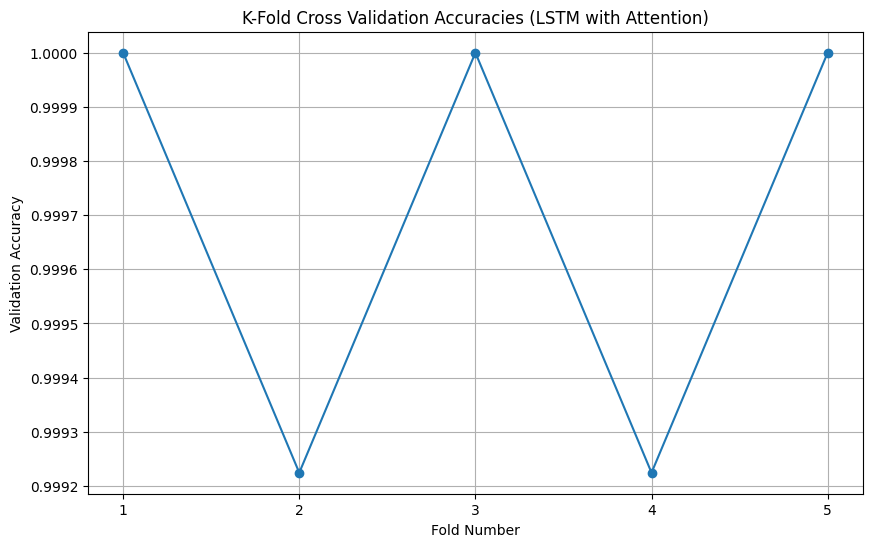

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


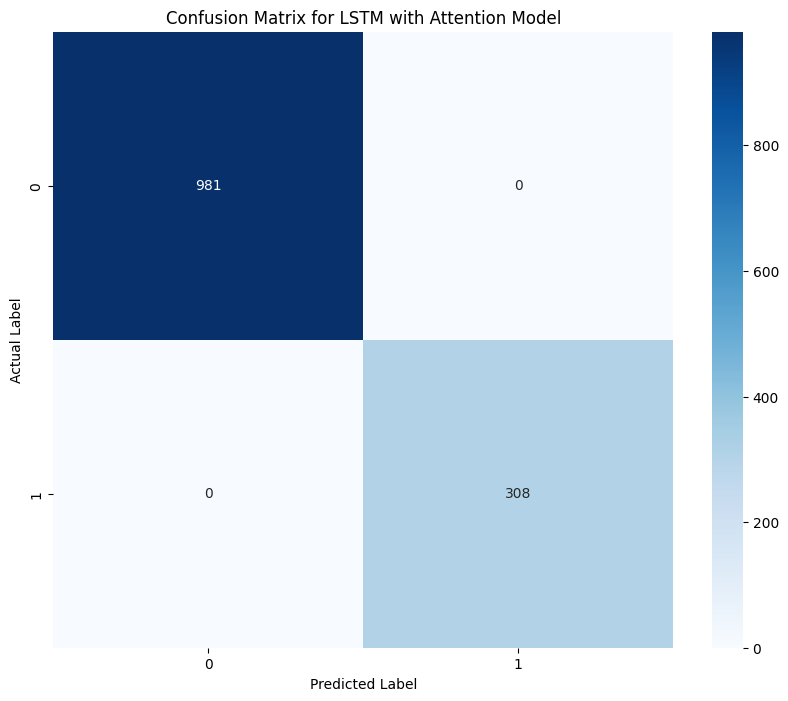

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Convert string labels to integers
label_mapping = {'benign': 0, 'malicious': 1}
data['label'] = data['label'].map(label_mapping)

# Extract features and labels
# features = data[['timestamp', 'q[0]', 'q[1]', 'q[2]', 'q[3]', 'delta_q_reset[0]', 'delta_q_reset[1]', 'delta_q_reset[2]',
#                  'delta_q_reset[3]', 'quat_reset_counter', 'lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'delta_alt',
#                  'eph_x', 'epv_x', 'terrain_alt', 'lat_lon_reset_counter', 'alt_reset_counter', 'terrain_alt_valid',
#                  'dead_reckoning', 'time_utc_usec', 'lat_y', 'lon_y', 'alt_y', 'alt_ellipsoid_y', 's_variance_m_s',
#                  'c_variance_rad', 'eph_y', 'epv_y', 'hdop', 'vdop', 'noise_per_ms', 'jamming_indicator', 'vel_m_s',
#                  'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s', 'cog_rad', 'timestamp_time_relative', 'heading_offset',
#                  'fix_type', 'vel_ned_valid', 'satellites_used', 'ref_lat', 'ref_lon', 'x', 'y', 'z', 'delta_xy[0]',
#                  'delta_xy[1]', 'delta_z', 'vx', 'vy', 'vz', 'z_deriv', 'delta_vxy[0]', 'delta_vxy[1]', 'delta_vz',
#                  'ax', 'ay', 'az', 'heading_y', 'delta_heading', 'ref_alt', 'dist_bottom', 'eph', 'epv', 'evh', 'evv',
#                  'xy_valid', 'z_valid', 'v_xy_valid', 'v_z_valid', 'xy_reset_counter', 'z_reset_counter',
#                  'vxy_reset_counter', 'vz_reset_counter', 'heading_reset_counter', 'xy_global', 'z_global',
#                  'dist_bottom_valid']].values
# labels = data['label'].values  # benign, malicious (converted to 0 and 1)

features = data[['lat_x', 'lon_x', 'alt_x', 'alt_ellipsoid_x', 'lat_y', 'lon_y', 'alt_y',
                 'alt_ellipsoid_y', 'vel_m_s', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s',
                 'cog_rad', 'heading_offset', 'heading_y', 'eph_x', 'epv_x', 'eph_y',
                 'epv_y', 'hdop', 'vdop', 'fix_type', 'satellites_used',
                 'noise_per_ms', 'jamming_indicator']].values

labels = data['label'].values  # Assuming 'label' is the name of the target column

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# One-hot encode the labels for binary classification
labels = to_categorical(labels, num_classes=2)

# Define Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)  # weights
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)  # bias
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)  # attention weights

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)  # activation function - tanh
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)  # activation function - softmax
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define LSTM with Attention Model
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # Attention mechanism
    attention_output = AttentionLayer()(lstm_out)

    # Classification
    classification = Dense(2, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# Input shape (1 time step, 79 features for the GPS data)
input_shape = (1, 25)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, val_index in kf.split(features):
    X_train, X_val = features[train_index], features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Reshape for LSTM (input needs to be 3D: [samples, time_steps, features])
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build and train the model
    model = build_lstm_attention_model(input_shape)
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=False)

    # Evaluate the model
    _, val_acc = model.evaluate(X_val, y_val)
    accuracies.append(val_acc)

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

# Plot the accuracies for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title('K-Fold Cross Validation Accuracies (LSTM with Attention)')
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, len(accuracies) + 1))
plt.grid()
plt.show()

# Get predictions for the final fold
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for LSTM with Attention Model')
plt.show()


In [ ]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add

# Custom TCN Block
def TCNBlock(filters, kernel_size, dilation_rate):
    def block(x):
        conv1 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal")(x)
        norm1 = BatchNormalization()(conv1)
        act1 = ReLU()(norm1)

        conv2 = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal")(act1)
        norm2 = BatchNormalization()(conv2)
        act2 = ReLU()(norm2)

        # Residual connection
        if x.shape[-1] != filters:
            x = Conv1D(filters, kernel_size=1, padding="same")(x)  # Adjust dimensions

        output = Add()([x, act2])  # Skip connection
        return output
    return block

# Build TCN with Attention Model
def build_tcn_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # Stacked TCN blocks
    tcn_out = TCNBlock(64, kernel_size=3, dilation_rate=1)(inputs)
    tcn_out = TCNBlock(64, kernel_size=3, dilation_rate=2)(tcn_out)
    tcn_out = TCNBlock(64, kernel_size=3, dilation_rate=4)(tcn_out)
    tcn_out = TCNBlock(64, kernel_size=3, dilation_rate=16)(tcn_out)
    tcn_out = TCNBlock(64, kernel_size=3, dilation_rate=256)(tcn_out)


    # Attention mechanism
    attention_output = AttentionLayer()(tcn_out)

    # Classification
    classification = Dense(2, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [ ]:
# Use the same K-Fold Cross-Validation setup
accuracies = []

for train_index, val_index in kf.split(features):
    X_train, X_val = features[train_index], features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Reshape for TCN (input needs to be 3D: [samples, time_steps, features])
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build and train the model
    model = build_tcn_attention_model(input_shape)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=False)

    # Evaluate the model
    _, val_acc = model.evaluate(X_val, y_val)
    accuracies.append(val_acc)

# Print the average accuracy across all folds
print(f'Average Accuracy (TCN with Attention): {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

# Plot the accuracies for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title('K-Fold Cross Validation Accuracies (TCN with Attention)')
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, len(accuracies) + 1))
plt.grid()
plt.show()

# Get predictions for the final fold
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for TCN with Attention Model')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6026e-05
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 3.0924e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1073e-04


KeyboardInterrupt: 

In [ ]:
pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism after the TCN layers
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Load dataset
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Select important features based on earlier suggestions
important_features = ['timestamp', 'lat_x', 'lon_x', 'alt_x', 'lat_y', 'lon_y', 'alt_y', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s', 'cog_rad', 'fix_type']
data = data[important_features + ['label']]

# Split features and label
X = data[important_features].values  # Features
y = data['label'].values  # Labels

# One-hot encode labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Adjust sequence_length dynamically if needed
sequence_length = 1  # Start with 1 to match features directly
while X_train.shape[1] % sequence_length != 0 and sequence_length <= X_train.shape[1]:
    sequence_length += 1

if X_train.shape[1] % sequence_length != 0:
    raise ValueError("Unable to find a valid sequence length. Check the dataset dimensions.")

num_features = X_train.shape[1] // sequence_length
X_train = X_train.reshape(-1, sequence_length, num_features)
X_test = X_test.reshape(-1, sequence_length, num_features)

# Build the model
input_shape = (sequence_length, num_features)
num_classes = y_encoded.shape[1]
model = build_tcn_attention_model(input_shape=input_shape, num_classes=num_classes)

# Train the model
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9058 - loss: 0.2016 - val_accuracy: 0.9922 - val_loss: 0.1129
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9988 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 9.9863e-04
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9975 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 3.7607e-04
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 1.5419e-04
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 1.9138e-04
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0029 

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism after the TCN layers
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax', name='classification')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Load dataset
data = pd.read_csv('/content/jamming-merged-gps-only.csv')

# Select important features based on earlier suggestions
important_features = ['timestamp', 'lat_x', 'lon_x', 'alt_x', 'lat_y', 'lon_y', 'alt_y', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s', 'cog_rad', 'fix_type']
data = data[important_features + ['label']]

# Split features and label
X = data[important_features].values  # Features
y = data['label'].values  # Labels

# One-hot encode labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Adjust sequence_length dynamically if needed
sequence_length = 1  # Start with 1 to match features directly
while X.shape[1] % sequence_length != 0 and sequence_length <= X.shape[1]:
    sequence_length += 1

if X.shape[1] % sequence_length != 0:
    raise ValueError("Unable to find a valid sequence length. Check the dataset dimensions.")

num_features = X.shape[1] // sequence_length
X = X.reshape(-1, sequence_length, num_features)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_losses = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Build the model
    input_shape = (sequence_length, num_features)
    num_classes = y_encoded.shape[1]
    model = build_tcn_attention_model(input_shape=input_shape, num_classes=num_classes)

    # Train the model
    epochs = 10
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)
    # loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

# Report average metrics
print(f"Average Loss across folds: {np.mean(fold_losses):.4f}")
print(f"Average Accuracy across folds: {np.mean(fold_accuracies):.4f}")


Test Loss: 8.457324292976409e-05
Test Accuracy: 1.0
Test Loss: 0.0016829170053824782
Test Accuracy: 0.9992241859436035
Test Loss: 0.0007048419211059809
Test Accuracy: 1.0
Test Loss: 0.001679731416516006
Test Accuracy: 0.9992241859436035
Test Loss: 0.0002514460647944361
Test Accuracy: 1.0
Average Loss across folds: 0.0009
Average Accuracy across folds: 0.9997
